In [1]:
import torch
import cv2 as cv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from PIL import Image as PILImage
from IPython.display import display
import webcolors
from skimage import color
from sklearn.cluster import KMeans
from collections import Counter
import time
from collections import defaultdict
import warnings
from datetime import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import deque, defaultdict

# Keep track of colors for smoothing
color_history = defaultdict(lambda: deque(maxlen=5))

# Create CSRT trackers per person
def create_tracker():
    return cv.legacy.TrackerKCF_create()

# 🎨 Load XKCD color dictionary (200+ names)
XKCD_COLORS = {
    name.replace('xkcd:', '').upper(): tuple(int(matplotlib.colors.to_rgb(code)[i]*255) for i in range(3))
    for name, code in matplotlib.colors.XKCD_COLORS.items()
}


In [2]:
# 👕 Group fine colors into major buckets
COLOR_CATEGORIES = {
    "RED": ["RED", "CRIMSON", "BLOOD", "CHERRY", "SCARLET", "BURGUNDY", "MAROON", "WINE", "TOMATO", "BRICK"],
    "BLUE": ["BLUE", "NAVY", "SKY", "AQUA", "CYAN", "TEAL", "AZURE", "INDIGO", "OCEAN"],
    "GREEN": ["GREEN", "LIME", "MINT", "OLIVE", "FOREST", "EMERALD"],
    "YELLOW": ["YELLOW", "GOLD", "GOLDEN", "LEMON", "MUSTARD"],
    "ORANGE": ["ORANGE", "PEACH", "APRICOT", "AMBER", "CORAL"],
    "BROWN": ["BROWN", "CHOCOLATE", "COFFEE", "TAN", "BEIGE", "BRONZE"],
    "PURPLE": ["PURPLE", "VIOLET", "LAVENDER", "PLUM", "MAUVE"],
    "PINK": ["PINK", "FUCHSIA", "ROSE", "SALMON", "MAGENTA"],
    "GRAY": ["GRAY", "GREY", "CHARCOAL", "SILVER"],
    "BLACK": ["BLACK"],
    "WHITE": ["WHITE", "IVORY", "CREAM"]
}

In [3]:
def map_to_main_color(detailed_color_name):
    """
    Map specific color names (e.g., 'Tomato Red') to broad color categories (e.g., 'RED').
    """
    color_upper = detailed_color_name.upper()
    
    for main_color, keywords in COLOR_CATEGORIES.items():
        for keyword in keywords:
            if keyword in color_upper:
                return main_color
    return "OTHER"  # If no match found


In [4]:
# to load yolo model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\User/.cache\torch\hub\ultralytics_yolov5_master
C:\Users\User/.cache\torch\hub\ultralytics_yolov5_master\utils\general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
YOLOv5  2025-6-22 Python-3.9.1rc1 torch-2.6.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [5]:
# loading the image

img_path = 'input/test2.jpeg'
image = cv.imread(img_path)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

In [6]:
#running the yolo interference

results = model(image_rgb)

In [7]:
# to convert to pandas df and filter for 'person' class

df = results.pandas().xyxy[0]
people = df[(df['name'] == 'person') & (df['confidence'] > 0.5)]


In [8]:
# to draw bouding boxes

image_copy = image.copy()
for i,row in people.iterrows():
    x1,y1,x2,y2 = map(int, [row['xmin'],row['ymin'],row['xmax'],row['ymax']])
    cv.rectangle(image_copy, (x1,y1),(x2,y2), (0,255,0), 2)
    label = f'Person {i+1}'
    (tw, th), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv.rectangle(image_copy, (x1, y1 - th - 6), (x1 + tw, y1), (0, 255, 0), -1)
    cv.putText(image_copy, label, (x1, y1 - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    

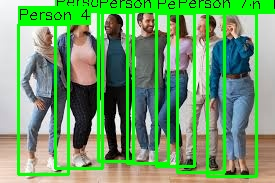

In [9]:
cv.imwrite("output/detected_people.jpg", image_copy)
display(PILImage.open("output/detected_people.jpg"))

In [10]:
os.makedirs("output/shirts_bb", exist_ok=True)
shirt_crops = []

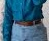

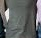

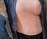

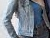

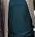

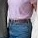

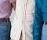

In [11]:
for idx, row in people.iterrows():
    x1, y1, x2, y2 = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
    person_crop = image_rgb[y1:y2, x1:x2]
    h, w, _ = person_crop.shape

    # Approximate shirt region (middle torso)
    y_top = int(0.25 * h)
    y_bottom = int(0.50 * h)
    shirt_crop = person_crop[y_top:y_bottom, 0:w]

    if shirt_crop.shape[0] < 20 or shirt_crop.shape[1] < 30:
        print(f"Crop size for person {idx+1}: {shirt_crop.shape}")

        continue

    filename = f"output/shirts_bb/shirt_{idx+1}.jpg"
    cv.imwrite(filename, cv.cvtColor(shirt_crop, cv.COLOR_RGB2BGR))
    shirt_crops.append((shirt_crop, filename))

    display(PILImage.open(filename))

In [15]:
from sklearn.cluster import KMeans
from collections import Counter

COMMON_COLORS = {
    "RED": (255, 0, 0),
    "GREEN": (0, 128, 0),
    "BLUE": (0, 0, 255),
    "YELLOW": (255, 255, 0),
    "ORANGE": (255, 165, 0),
    "PURPLE": (128, 0, 128),
    "PINK": (255, 192, 203),
    "BROWN": (139, 69, 19),
    "GRAY": (128, 128, 128),
    "WHITE": (255, 255, 255),
    "BLACK": (0, 0, 0),
    "CYAN": (0, 255, 255),
    "MAROON": (128, 0, 0),
    "NAVY": (0, 0, 128),
    "GOLD": (255, 215, 0)
}


def get_dominant_color_mode(image, k=3):
    pixels = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pixels)
    counts = Counter(kmeans.labels_)
    dominant = kmeans.cluster_centers_[counts.most_common(1)[0][0]]
    return tuple(map(int, dominant))

def classify_color_lab(rgb):
    min_dist = float("inf")
    closest_name = None
    for name, ref_rgb in COMMON_COLORS.items():
        dist = np.linalg.norm(np.array(rgb) - np.array(ref_rgb))
        if dist < min_dist:
            min_dist = dist
            closest_name = name
    return closest_name





In [16]:
def process_video_smart(video_path, output_path=None, detect_every=15):
    cap = cv.VideoCapture(video_path)
    width  = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps    = int(cap.get(cv.CAP_PROP_FPS))

    if output_path is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_path = f'output/video_output_{timestamp}.avi'
    
    out = cv.VideoWriter(output_path, cv.VideoWriter_fourcc(*'XVID'), fps, (width, height))

    frame_idx = 0
    trackers = []
    person_ids = []
    id_counter = 1

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        frame_disp = frame.copy()

        if frame_idx % detect_every == 0:
            # Re-detect people every N frames using YOLO
            results = model(frame_rgb)
            df = results.pandas().xyxy[0]
            people = df[df['name'] == 'person']

            trackers = []
            person_ids = []

            for i, row in people.iterrows():
                x1, y1, x2, y2 = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
                bbox = (x1, y1, x2 - x1, y2 - y1)
                tracker = create_tracker()
                tracker.init(frame, bbox)
                trackers.append(tracker)
                person_ids.append(id_counter)
                id_counter += 1

        else:
            # Update all trackers
            new_boxes = []
            for tracker in trackers:
                success, bbox = tracker.update(frame)
                new_boxes.append(bbox if success else None)

            # Reassign if people moved
            for i, bbox in enumerate(new_boxes):
                if bbox is None:
                    continue
                x, y, w, h = map(int, bbox)
                shirt_crop = frame_rgb[y + int(h * 0.25): y + int(h * 0.5), x: x + w]

                if shirt_crop.shape[0] < 20 or shirt_crop.shape[1] < 20:
                    continue

                # Detect color and smooth
                dom_color = get_dominant_color_mode(shirt_crop)
                color_history[person_ids[i]].append(dom_color)

                # Average RGB across frames
                smooth_color = np.mean(color_history[person_ids[i]], axis=0).astype(int)
                color_name = classify_color_lab(tuple(smooth_color))

                label = f'{color_name.title()} Shirt'
                cv.rectangle(frame_disp, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv.putText(frame_disp, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.6, (36, 255, 12), 2)

        out.write(frame_disp)
        cv.imshow("Shirt Color Detection", frame_disp)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

        frame_idx += 1

    cap.release()
    out.release()
    cv.destroyAllWindows()


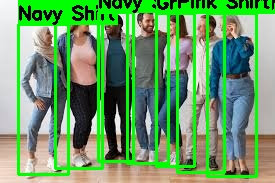

In [17]:
labeled_image = image.copy()

for idx, row in people.iterrows():
    x1, y1, x2, y2 = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
    person_crop = image_rgb[y1:y2, x1:x2]
    h, w, _ = person_crop.shape

    # shirt crop 
    y_top = int(0.25 * h)
    y_bottom = int(0.50 * h)
    shirt_crop = person_crop[y_top:y_bottom, 0:w]

    if shirt_crop.shape[0] < 20 or shirt_crop.shape[1] < 20:
        print(f"Skipped: Crop too small for person {idx+1}")
        continue

    # dominant color
    dom_color = get_dominant_color_mode(shirt_crop)
    color_name = classify_color_lab(dom_color)


    # bounding box
    cv.rectangle(labeled_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Label with person ID + color
    label = f'{color_name.title()} Shirt'  # 👈 better label
    (tw, th), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    cv.rectangle(labeled_image, (x1, y1 - th - 10), (x1 + tw, y1), (0, 255, 0), -1)
    cv.putText(labeled_image, label, (x1, y1 - 5),
               cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)


# Save and display
cv.imwrite("output/labeled_with_colors.jpg", labeled_image)
display(PILImage.open("output/labeled_with_colors.jpg"))




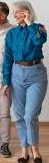

👤 Person 1 — Shirt Color Detected: GRAY (RGB: (41, 101, 133))


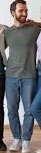

👤 Person 2 — Shirt Color Detected: GRAY (RGB: (99, 103, 101))


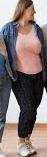

👤 Person 3 — Shirt Color Detected: GRAY (RGB: (198, 151, 141))


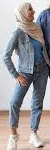

👤 Person 4 — Shirt Color Detected: NAVY (RGB: (55, 61, 73))


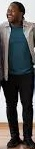

👤 Person 5 — Shirt Color Detected: NAVY (RGB: (38, 59, 70))


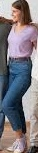

👤 Person 6 — Shirt Color Detected: GRAY (RGB: (61, 70, 84))


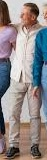

👤 Person 7 — Shirt Color Detected: PINK (RGB: (221, 214, 213))


In [18]:
os.makedirs("output/people_cropped", exist_ok=True)

for idx, row in people.iterrows():
    x1, y1, x2, y2 = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
    person_crop = image_rgb[y1:y2, x1:x2]
    h, w, _ = person_crop.shape

    # Approximate shirt region (mid-torso)
    y_top = int(0.25 * h)
    y_bottom = int(0.50 * h)
    shirt_crop = person_crop[y_top:y_bottom, 0:w]

    if shirt_crop.shape[0] < 20 or shirt_crop.shape[1] < 20:
        print(f"❌ Skipped person {idx+1}: Shirt crop too small.")
        continue

    # Dominant color & matched name
    dom_color = get_dominant_color_mode(shirt_crop)
    color_name = classify_color_lab(dom_color)

    # Save cropped person image
    save_path = f"output/people_cropped/person_{idx+1}.jpg"
    cv.imwrite(save_path, cv.cvtColor(person_crop, cv.COLOR_RGB2BGR))
    display(PILImage.open(save_path))

    # Output label text in console
    print(f"👤 Person {idx+1} — Shirt Color Detected: {color_name.upper()} (RGB: {dom_color})")

In [28]:
from collections import defaultdict

# Re-run just the grouping part based on already detected results
# Initialize lists and dict for grouping
person_ids = []
all_broad_colors = []
color_groups = {}

for idx, row in people.iterrows():
    x1, y1, x2, y2 = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
    person_crop = image_rgb[y1:y2, x1:x2]
    h, w, _ = person_crop.shape

    # Approximate shirt region
    y_top = int(0.25 * h)
    y_bottom = int(0.50 * h)
    shirt_crop = person_crop[y_top:y_bottom, 0:w]

    if shirt_crop.shape[0] < 20 or shirt_crop.shape[1] < 20:
        print(f"❌ Skipped person {idx+1}: Shirt crop too small.")
        continue

    # Get dominant color and match
    dom_color = get_dominant_color_mode(shirt_crop)
    fine_color = classify_color_lab(dom_color)
    broad_color = map_to_main_color(fine_color)

    # Save cropped image
    save_path = f"output/people_cropped/person_{idx+1}.jpg"
    cv.imwrite(save_path, cv.cvtColor(person_crop, cv.COLOR_RGB2BGR))
    display(PILImage.open(save_path))

    # Print details
    print(f"👤 Person {idx+1} — Shirt Color Detected: {fine_color.upper()} → Group: {broad_color.upper()}")

    # Append for summary
    person_ids.append(idx + 1)
    all_broad_colors.append(broad_color)

    # Grouping
    color_groups.setdefault(broad_color, []).append(idx + 1)

# ✅ Print summary
print("\n🎨 Shirt Color Groups:")
for color, ids in color_groups.items():
    print(f"👕 {color:<10}: {len(ids)} person(s) → IDs {ids}")



NameError: name 'all_broad_colors' is not defined


🎨 Shirt Color Groups:
👕 PINK      : 7 person(s) → IDs [1, 2, 3, 4, 5, 6, 7]



🎨 Shirt Color Groups:
👕 GRAY      : 4 person(s) → IDs [1, 2, 3, 6]
👕 NAVY      : 2 person(s) → IDs [4, 5]
👕 PINK      : 1 person(s) → IDs [7]


In [22]:
import numpy as np
from skimage import color

rgb = (255, 0, 0)
rgb_array = np.array([[rgb]], dtype=np.uint8) / 255.0
lab = color.rgb2lab(rgb_array)[0][0]
print(lab)


[     53.241      80.092      67.203]


In [24]:
# 🎯 Option B: Filter People by User-Defined Shirt Color
target_color = input("Enter the shirt color to filter: ").strip().lower()

matched_ids = []

print(f"\n🎯 Filtering people by shirt color: {target_color.upper()}\n")

for idx, row in people.iterrows():
    x1, y1, x2, y2 = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
    person_crop = image_rgb[y1:y2, x1:x2]
    h, w, _ = person_crop.shape

    # Approximate shirt region
    y_top = int(0.25 * h)
    y_bottom = int(0.50 * h)
    shirt_crop = person_crop[y_top:y_bottom, 0:w]

    if shirt_crop.shape[0] < 20 or shirt_crop.shape[1] < 20:
        continue

    dom_color = get_dominant_color_mode(shirt_crop)
    detected_color = classify_color_lab(dom_color)

    if detected_color.lower() == target_color.lower():
        matched_ids.append(idx + 1)
        # Display image
        print(f"✅ Person {idx+1} - {detected_color.upper()} Shirt")
        save_path = f"output/filtered/person_{idx+1}.jpg"
        os.makedirs("output/filtered", exist_ok=True)
        cv.imwrite(save_path, cv.cvtColor(person_crop, cv.COLOR_RGB2BGR))
        display(PILImage.open(save_path))

# Final summary
print("✅ Matches Found:", len(matched_ids))
print("👥 Matched Person IDs:", matched_ids if matched_ids else "❌ No matching people found.")


Enter the shirt color to filter:  white



🎯 Filtering people by shirt color: WHITE

✅ Matches Found: 0
👥 Matched Person IDs: ❌ No matching people found.


In [25]:
# Replace with your video path or use 0 for webcam
process_video_smart("input/video2.mp4")


In [26]:
print(cv.__version__)

4.11.0


In [29]:
# ✅ Color group summary (after processing all people)
print("\n🎨 Shirt Color Groups:")
grouped = {}
person_ids = []
all_broad_colors = []
for pid, color in zip(person_ids, all_broad_colors):
    grouped.setdefault(color, []).append(pid)

for main_color, ids in grouped.items():
    print(f"👕 {main_color:<10}: {len(ids)} person(s) → IDs {ids}")



🎨 Shirt Color Groups:
